In [1]:
import os
from collections import Counter
from collections import defaultdict
from pprint import pprint

import pandas as pd
import yaml

from m2t.dataset_utils import fetch_audio_start_end


/Users/jpgard/opt/miniconda3/envs/m2t/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
VERBOSE = False

# Medleydb

In [78]:
# v5
# MODEL_COMPLETION_TEXT_COLNAME = 'model_completion_text'
# medleydb_inference = pd.read_csv("../inference-results/v5/infer_results_medleydb_instruments_v5_100k.csv")

# # v8
# MODEL_COMPLETION_TEXT_COLNAME = 'model_completion_text'
# medleydb_inference = pd.read_csv("/Users/joshg/projects/music2text/inference-results/v8/infer_results_medleydb_instruments_v8_100000steps.csv")

# v9
# MODEL_COMPLETION_TEXT_COLNAME = 'model_completion_text'
# medleydb_inference = pd.read_csv("/Users/joshg/projects/music2text/inference-results/v9/infer_results_medleydb_instruments_v9_100000steps.csv")


# MODEL_COMPLETION_TEXT_COLNAME = 'ltu_caption'
# medleydb_inference = pd.read_csv("../inference-results/ltu/listen_think_understand_medleydb_instruments.csv")

MODEL_COMPLETION_TEXT_COLNAME = 'imagebind_llm_caption'
medleydb_inference = pd.read_csv("../inference-results/imagebind-llm/imagebind-llm_medleydb_instruments.csv")


# ablations
# MODEL_COMPLETION_TEXT_COLNAME = 'model_completion_text'
# medleydb_inference = pd.read_csv("/Users/joshg/projects/music2text/inference-results/ablations/infer_results_medleydb_instruments_clap_100000steps.csv")
# medleydb_inference = pd.read_csv("/Users/joshg/projects/music2text/inference-results/ablations/infer_results_medleydb_instruments_ablation-mpt1b_100000steps.csv")
# medleydb_inference = pd.read_csv("/Users/joshg/projects/music2text/inference-results/ablations/infer_results_medleydb_instruments_data-ablation-1pct_100000steps.csv")
# medleydb_inference = pd.read_csv("/Users/joshg/projects/music2text/inference-results/ablations/infer_results_medleydb_instruments_data-ablation-10pct_100000steps.csv")
# medleydb_inference = pd.read_csv("/Users/joshg/projects/music2text/inference-results/ablations/infer_results_medleydb_instruments_data-ablation-50pct_100000steps.csv")


def _id_parse_fn(id_str):
    if "_MIX" in id_str:
        return os.path.basename(id_str).split("_MIX")[0]
    else:
        return id_str


medleydb_inference['id'] = medleydb_inference['example_id'].apply(_id_parse_fn)
medleydb_inference.head()

,example_id,prompt,imagebind_llm_caption,id
0,KarimDouaidy_Yatora_MIX-start30.000-end60.000,"List the instruments you hear in this clip, in...","In this clip, you can hear a guitar, a keyboar...",KarimDouaidy_Yatora
1,MusicDelta_ChineseJiangNan_MIX-start0.000-end2...,"List the instruments you hear in this clip, in...","In this clip, you can hear a piano, a violin, ...",MusicDelta_ChineseJiangNan
2,ClaraBerryAndWooldog_AirTraffic_MIX-start30.00...,"List the instruments you hear in this clip, in...","In this clip, you can hear a guitar, a piano, ...",ClaraBerryAndWooldog_AirTraffic
3,MusicDelta_FreeJazz_MIX-start30.000-end60.000,"List the instruments you hear in this clip, in...","In this clip, you can hear a saxophone, a trum...",MusicDelta_FreeJazz
4,CroqueMadame_Oil_MIX-start30.000-end60.000,"List the instruments you hear in this clip, in...","In this clip, you can hear a guitar, bass, and...",CroqueMadame_Oil


In [79]:
if VERBOSE:
    print(medleydb_inference[MODEL_COMPLETION_TEXT_COLNAME].tolist())

In [80]:
# load medleydb results

def load_medleydb_instruments(medleydb_dir="../datasets/medleydb"):
    audio_files = os.listdir(os.path.join(medleydb_dir, "wav-crop"))

    mdb_data = defaultdict(dict)
    for audio_file in audio_files:
        start, end = fetch_audio_start_end(audio_file)
        if start == 0. and end == 0.:
            print(f"skipping file {audio_file} with zero duration.")
            continue
        mdb_id = audio_file.split("_MIX-start")[0]
        mdb_data[mdb_id]["audio_file"] = audio_file
        mdb_data[mdb_id]["start"] = start
        mdb_data[mdb_id]["end"] = end
        meta_fp = os.path.join(medleydb_dir, "metadata", mdb_id + "_METADATA.yaml")
        with open(meta_fp, "r") as f:
            metadata = yaml.safe_load(f)
        mdb_data[mdb_id]["metadata"] = metadata

        stems_to_instruments = {k: v['instrument'] for k, v in metadata['stems'].items()}
        #         print(stems_to_instruments)

        activations_fp = os.path.join(medleydb_dir, "activations-original", mdb_id + "_ACTIVATION_CONF.lab")
        activations = pd.read_csv(activations_fp).rename(columns=stems_to_instruments)
        activations = activations.query(f"time >= {start} & time <= {end}")
        mdb_data[mdb_id]["activations"] = activations

        activated_counts = (activations.iloc[:, 1:] > 0.5).sum()
        mdb_data[mdb_id]["active_instruments"] = activated_counts.index[activated_counts > 0].tolist()

    return mdb_data


mdb_data = load_medleydb_instruments()

skipping file MusicDelta_Beethoven_MIX-start0.000-end0.000.wav with zero duration.
skipping file MusicDelta_Country2_MIX-start0.000-end0.000.wav with zero duration.
skipping file MusicDelta_Hendrix_MIX-start0.000-end0.000.wav with zero duration.
skipping file MusicDelta_InTheHalloftheMountainKing_MIX-start0.000-end0.000.wav with zero duration.
skipping file MusicDelta_Punk_MIX-start0.000-end0.000.wav with zero duration.
skipping file MusicDelta_Reggae_MIX-start0.000-end0.000.wav with zero duration.
skipping file MusicDelta_Rock_MIX-start0.000-end0.000.wav with zero duration.
skipping file MusicDelta_Rockabilly_MIX-start0.000-end0.000.wav with zero duration.
skipping file MusicDelta_Vivaldi_MIX-start0.000-end0.000.wav with zero duration.
skipping file MusicDelta_Zeppelin_MIX-start0.000-end0.000.wav with zero duration.


In [81]:
for k in sorted(mdb_data.keys()):
    print(f"{k} instruments: {mdb_data[k]['active_instruments']}")

AClassicEducation_NightOwl instruments: ['electric bass', 'drum set', 'distorted electric guitar', 'distorted electric guitar', 'clean electric guitar', 'male singer', 'synthesizer', 'vocalists', 'tambourine', 'fx/processed sound', 'male singer']
AimeeNorwich_Child instruments: ['drum set', 'electric bass', 'clean electric guitar', 'female singer', 'vocalists', 'acoustic guitar']
AimeeNorwich_Flying instruments: ['drum set', 'electric bass', 'clean electric guitar', 'clean electric guitar', 'fx/processed sound', 'fx/processed sound']
AlexanderRoss_GoodbyeBolero instruments: ['acoustic guitar', 'clean electric guitar', 'electric bass', 'drum set', 'male singer', 'brass section', 'viola section']
AlexanderRoss_VelvetCurtain instruments: ['acoustic guitar', 'male singer']
AmarLal_Rest instruments: ['clean electric guitar']
AmarLal_SpringDay1 instruments: ['acoustic guitar']
Auctioneer_OurFutureFaces instruments: ['electric bass', 'vocalists', 'drum set', 'clean electric guitar', 'horn sec

In [82]:
# print all of the active instrumnets
instruments = []
for k in mdb_data.keys():
    instruments.extend(mdb_data[k]['active_instruments'])
if VERBOSE:
    pprint(Counter(instruments))

In [1]:
# Heuristic here is to map these to the high-level midi 'classes'; that is: (program_num // 8)*8.
medleydb_instruments_mapping = \
    {
        'Main System': None,
        'acoustic guitar': 'guitar',
        'alto saxophone': 'saxophone',
        'auxiliary percussion': 'drum',
        'bamboo flute': 'flute',
        'baritone saxophone': 'saxophone',
        'bass clarinet': 'clarinet',
        'bass drum': 'drum',
        'bassoon': 'bassoon',
        'brass section': None,
        'cello': 'cello',
        'cello section': 'cello',
        'chimes': None,
        'claps': None,
        'clarinet': 'clarinet',
        'clarinet section': 'clarinet',
        'clean electric guitar': 'guitar',
        'cymbal': 'drum',
        'darbuka': None,
        'distorted electric guitar': 'guitar',
        'dizi': 'flute',
        'double bass': 'bass',
        'drum machine': 'drum',
        'drum set': 'drum',
        'electric bass': 'bass',
        'electric piano': 'piano',
        'erhu': None,
        'female singer': 'vocals',
        'flute': 'flute',
        'flute section': 'flute',
        'french horn': 'horn',
        'fx/processed sound': None,
        'gu': None,
        'guzheng': None,
        'harp': 'harp',
        'horn section': 'horn',
        'kick drum': 'drum',
        'lap steel guitar': 'guitar',
        'liuqin': None,
        'male singer': 'vocals',
        'mandolin': 'guitar',
        'oboe': 'oboe',
        'oud': None,
        'piano': 'piano',
        'piccolo': 'flute',
        'sampler': None,
        'shaker': None,
        'snare drum': 'drum',
        'soprano saxophone': 'saxophone',
        'string section': None,
        'synthesizer': 'synthesizer',
        'tabla': None,
        'tack piano': 'piano',
        'tambourine': None,
        'tenor saxophone': 'saxophone',
        'timpani': None,
        'trumpet': 'trumpet',
        'trumpet section': 'trumpet',
        'tuba': 'tuba',
        'vibraphone': None,
        'viola': 'viola',
        'viola section': 'viola',
        'violin': 'violin',
        'violin section': 'violin',
        'vocalists': 'vocals',
        'yangqin': None,
        'zhongruan': None,
    }

In [2]:
print(len(set(medleydb_instruments_mapping.values())))

19


In [84]:
mdb_active_instruments_df = pd.DataFrame(
    [{'id': k, 'active_instruments': mdb_data[k]['active_instruments']} for k in mdb_data.keys()])

In [85]:
df = medleydb_inference.merge(mdb_active_instruments_df, on='id')

In [86]:
df['baseline'] = 'drum set electric bass vocals piano guitar'

In [87]:
def medleydb_instrument_in_response(inst: str, response: str) -> bool:
    # inst_mapped is thr string we will actually check for.
    inst_mapped = medleydb_instruments_mapping[inst]
    if inst_mapped is None:
        raise ValueError(f"instrument {inst} is mapped to None.")

    # drop any sentences contining 'no'
    sentences = [s for s in response.split(".") if " no " not in s]
    dropped_sentences = [s for s in response.split(".") if " no " in s]
    if dropped_sentences and VERBOSE:
        print(f"dropped the following sentences: {dropped_sentences}")

    for s in sentences:
        if inst_mapped in s.lower():
            if VERBOSE: print(f"[CORRECT] found instrument {inst_mapped} in sentence {s}")
            return True
    if VERBOSE: print(f"[MISSED] missing instrument {inst_mapped} from response {response}")
    return False


def compute_f1(df, model_completion_text_colname):
    f1_scores = {}
    for _, row in df.iterrows():
        if VERBOSE: print("#" * 50)
        if VERBOSE: print(f"processing track {row['id']} with active instruments {row['active_instruments']}")
        response_text = row[model_completion_text_colname]
        if VERBOSE: print(f"response text is {response_text}")

        tp = 0
        fp = 0
        fn = 0

        active_instruments = [k for k, v in medleydb_instruments_mapping.items()
                              if k in row['active_instruments']
                              and v is not None]
        # check for true positives
        for active_inst in active_instruments:

            if medleydb_instrument_in_response(active_inst, response_text):
                # Case: instrument is in response, and it should be: true positive.
                tp += 1
            else:
                # Case: instrument is not in response, but it should be: false negative.
                fn += 1

        inactive_instruments = [k for k, v in medleydb_instruments_mapping.items()
                                if k not in row['active_instruments']
                                and v is not None]
        for inactive_inst in inactive_instruments:
            if medleydb_instrument_in_response(inactive_inst, response_text):
                fp += 1
        try:
            f1_scores[row['id']] = 2 * tp / (2 * tp + fp + fn)
        except ZeroDivisionError:
            print(f"ZeroDivisionError for response_text {response_text} and active instruments {active_instruments}")
    f1_overall = pd.DataFrame.from_dict(f1_scores, orient='index', columns=['f1']).reset_index(names='id')['f1'].mean()
    return f1_overall

In [88]:
from tqdm import tqdm

f1_scores = []
for _ in tqdm(range(1000)):
    tmp = df.sample(n=len(df), replace=True)
    f1 = compute_f1(tmp, MODEL_COMPLETION_TEXT_COLNAME)
    f1_scores.append(f1)
print(f"overall F1 score is {f1}")

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.34it/s]

overall F1 score is 0.2526275900339256


ci width is 0.015987614055040233
ci center is 0.25054615459870794


(array([  6.,  30.,  62., 138., 210., 218., 162., 102.,  47.,  25.]),
 array([0.22191206, 0.22720315, 0.23249424, 0.23778533, 0.24307642,
        0.24836751, 0.2536586 , 0.25894969, 0.26424077, 0.26953186,
        0.27482295]),
 <BarContainer object of 10 artists>)

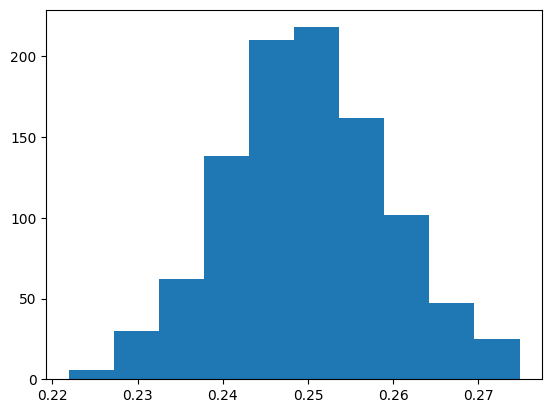

In [89]:
f1s = f1_scores
import numpy as np

ci_lower, ci_upper = np.quantile(f1s, [0.05, 0.95])
ci_width = (ci_upper - ci_lower) / 2
print(f"ci width is {ci_width}")

ci_center = (ci_upper + ci_lower) / 2
print(f"ci center is {ci_center}")

import matplotlib.pyplot as plt

plt.hist(f1s)

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 18.87it/s]

ci width is 0.016985299601008474
ci center is 0.2523184543008168


(array([  2.,   6.,  23.,  74., 274., 303., 200.,  92.,  23.,   3.]),
 array([0.20810889, 0.21617856, 0.22424822, 0.23231788, 0.24038754,
        0.2484572 , 0.25652687, 0.26459653, 0.27266619, 0.28073585,
        0.28880551]),
 <BarContainer object of 10 artists>)

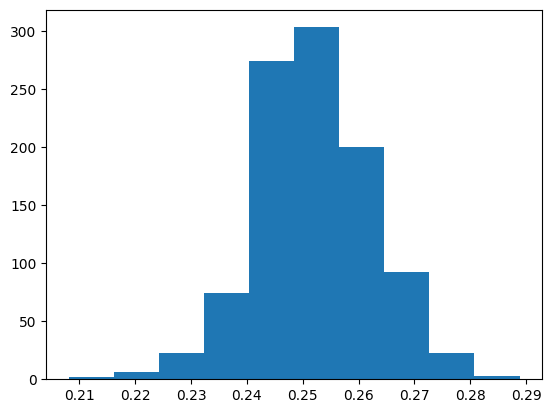

In [90]:
# baseline
from tqdm import tqdm

f1_scores = []
for _ in tqdm(range(1000)):
    tmp = df.sample(n=len(df), replace=True)
    f1 = compute_f1(tmp, 'baseline')
    f1_scores.append(f1)

f1s = f1_scores
import numpy as np

ci_lower, ci_upper = np.quantile(f1s, [0.05, 0.95])
ci_width = (ci_upper - ci_lower) / 2
print(f"ci width is {ci_width}")

ci_center = (ci_upper + ci_lower) / 2
print(f"ci center is {ci_center}")

import matplotlib.pyplot as plt

plt.hist(f1s)